In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import Input, Model
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16



local_directory_path = r'/content/drive/MyDrive/archive (1)/processed_images'

for dirname, _, filenames in os.walk(local_directory_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/archive (1)/processed_images/test/normal/image_253.png
/content/drive/MyDrive/archive (1)/processed_images/test/normal/image_264.png
/content/drive/MyDrive/archive (1)/processed_images/test/normal/image_266.png
/content/drive/MyDrive/archive (1)/processed_images/test/normal/image_263.png
/content/drive/MyDrive/archive (1)/processed_images/test/normal/image_254.png
/content/drive/MyDrive/archive (1)/processed_images/test/normal/image_268.png
/content/drive/MyDrive/archive (1)/processed_images/test/normal/image_265.png
/content/drive/MyDrive/archive (1)/processed_images/test/normal/image_269.png
/content/drive/MyDrive/archive (1)/processed_images/test/normal/image_246.png
/content/drive/MyDrive/archive (1)/processed_images/test/normal/image_250.png
/content/drive/MyDrive/archive (1)/processed_images/test/normal/image_260.png
/content/drive/MyDrive/archive (1)/processed_images/test/normal/image_258.png
/content/drive/MyDrive/archive (1)/processed_images/test/normal/

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile


IMAGE_SIZE = [150, 150]

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    shear_range = 0.1,
                                    zoom_range = 0.1,
                                    horizontal_flip = True

                                   )

test_datagen = ImageDataGenerator( rescale = 1.0/255. )

train_generator = train_datagen.flow_from_directory(r'/content/drive/MyDrive/archive (1)/processed_images/train',
                                                    batch_size = 32,
                                                    class_mode = 'categorical',
                                                    target_size = (150, 150))

test_generator =  test_datagen.flow_from_directory( r'/content/drive/MyDrive/archive (1)/processed_images/test',
                                                          batch_size  = 32,
                                                          class_mode  = 'categorical',
                                                          target_size = (150, 150),
                                                          shuffle = False
                                                    )

Found 491 images belonging to 2 classes.
Found 121 images belonging to 2 classes.


In [4]:
#vgg 16


# Input layer (same as Custom CNN)
inputs = Input(shape=(150, 150, 3), name="input_image")

# Load VGG16 base model
vgg16_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_tensor=inputs
)



set_trainable = False
for layer in vgg16_base.layers:
    if layer.name == 'block5_conv1': # Yahan se training shuru hogi
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False





# IMPORTANT: Choose last conv layer for Grad-CAM
# VGG16 last conv layer = block5_conv3
gradcam_layer = vgg16_base.get_layer("block5_conv3").output

# Custom classification head (same style as Custom CNN)
x = MaxPooling2D(name="pool_block5")(gradcam_layer)
#x = Flatten(name="flatten")(x)
x = GlobalAveragePooling2D(name="gap")(gradcam_layer)
x = Dense(128, activation='relu', name="fc1")(x)
x = Dropout(0.5, name="dropout")(x)
outputs = Dense(2, activation='softmax', name="output")(x)

# Final model
model_vgg = Model(inputs=inputs, outputs=outputs)

# Compile
model_vgg.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
model_vgg.summary()




58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,610 (56.38 MB)

 Trainable params: 7,145,346 (27.26 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [5]:
# Train the model
history = model_vgg.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 249s 15s/step - accuracy: 0.5580 - loss: 0.7203 - val_accuracy: 0.8264 - val_loss: 0.5677
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6380 - loss: 0.6217 - val_accuracy: 0.8678 - val_loss: 0.4577
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7066 - loss: 0.5583 - val_accuracy: 0.8678 - val_loss: 0.3654
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8199 - loss: 0.4127 - val_accuracy: 0.8926 - val_loss: 0.2975
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8687 - loss: 0.3640 - val_accuracy: 0.8926 - val_loss: 0.2567
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8640 - loss: 0.3503 - val_accuracy: 0.9008 - val_loss: 0.2338
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8636 - loss: 0.3104 - val_accuracy: 0.9339 - val_loss: 0.2000
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8904 - loss: 0.2660 - val_accuracy: 0.9256 - val_los

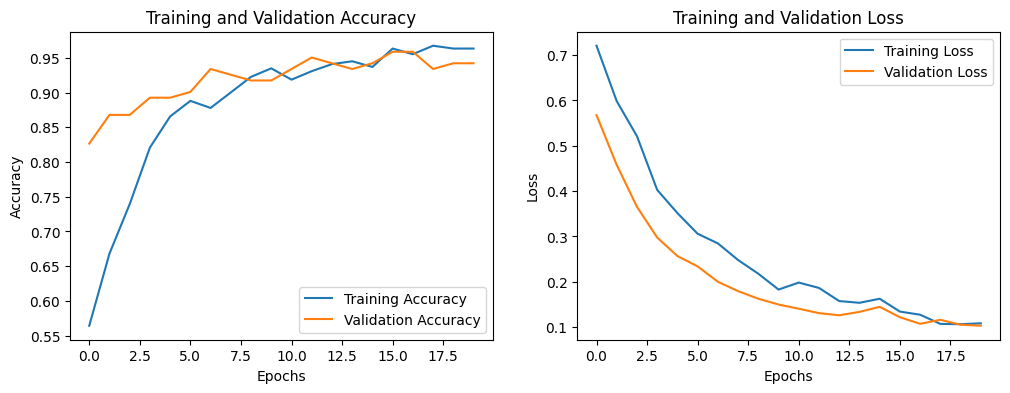

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 796ms/step - accuracy: 0.9477 - loss: 0.0986
Test Accuracy: 94.21%
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.95      0.93      0.94        61
     Class 1       0.93      0.95      0.94        60

    accuracy                           0.94       121
   macro avg       0.94      0.94      0.94       121
weighted avg       0.94      0.94      0.94       121


Confusion Matrix:
[[57  4]
 [ 3 57]]


In [6]:
# Plot training history
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

# Evaluate the model
test_loss, test_accuracy = model_vgg.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Generate predictions and true labels
y_true = test_generator.classes  # True labels
y_pred = model_vgg.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)   # Get predicted class indices


# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=['Class 0', 'Class 1']))  # Assuming 'Class 0' and 'Class 1' are your class names

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred_classes))





In [7]:
print(train_generator.class_indices)
print(test_generator.class_indices)


{'cataract': 0, 'normal': 1}
{'cataract': 0, 'normal': 1}


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 795ms/step


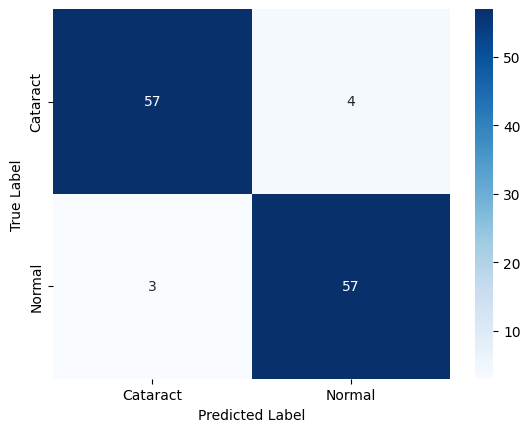

In [8]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

test_generator.reset()

preds = model_vgg.predict(test_generator)
y_pred = np.argmax(preds, axis=1)
y_true = test_generator.classes

conf_mat = confusion_matrix(y_true, y_pred)

sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Cataract', 'Normal'],
    yticklabels=['Cataract', 'Normal']
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_image']
Received: inputs=Tensor(shape=(1, 150, 150, 3))
  warnings.warn(msg)


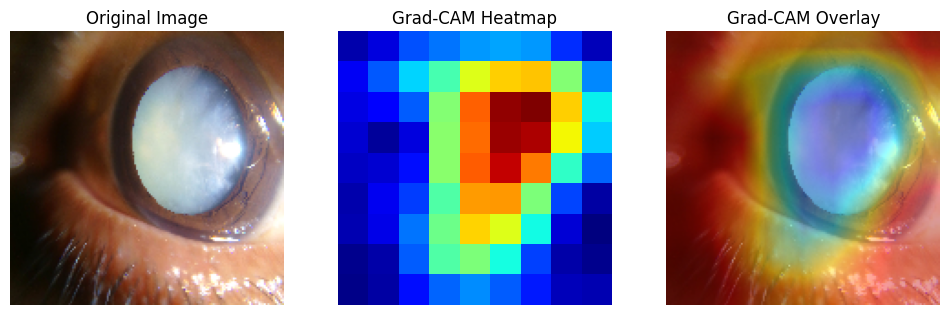

In [19]:
# ===================== IMPORTS =====================
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

# ===================== USER INPUT =====================
img_path = "/content/drive/MyDrive/archive (1)/processed_images/test/cataract/image_254.png"
#img_path = "/content/drive/MyDrive/archive (1)/processed_images/test/cataract/image_300.png"
#img_path = "/content/drive/MyDrive/archive (1)/processed_images/test/normal/image_289.png"
class_labels = ["Cataract", "Normal"]
last_conv_layer_name = "block5_conv3"



# ===================== LOAD & PREPROCESS IMAGE =====================
img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)   # VGG16 correct preprocessing

# ===================== GRAD-CAM FUNCTION =====================
def advanced_gradcam(model, img_array, last_conv_layer_name, pred_index=None):


    # Temporarily create linear-output model
    grad_model = tf.keras.models.Model(
         model_vgg.inputs,
         [model_vgg.get_layer(last_conv_layer_name).output,
         model_vgg.layers[-1].input]
         )


    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_score = predictions[:, pred_index]

    grads = tape.gradient(class_score, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap) + 1e-8

    return heatmap.numpy(), predictions.numpy()

# ===================== RUN GRAD-CAM =====================
heatmap, preds = advanced_gradcam(
    model_vgg,
    img_array,
    last_conv_layer_name
)



# preds is output of model.predict(...)
preds = preds.reshape(-1)[:model_vgg.output_shape[-1]]

pred_index = int(np.argmax(preds))
confidence = float(preds[pred_index])



# ===================== VISUALIZATION =====================
img_original = cv2.imread(img_path)
img_original = cv2.resize(img_original, (150, 150))
img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

heatmap_resized = cv2.resize(heatmap, (150, 150))
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

overlay = cv2.addWeighted(img_original, 0.6, heatmap_colored, 0.4, 0)

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img_original)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(heatmap, cmap="jet")
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title("Grad-CAM Overlay")
plt.axis("off")

plt.show()


In [20]:
# Normal prediction (without Grad-CAM)

import numpy as np

# 1. LABELS DEFINE (Alphabetical Order)
# this is impo after training folder check
class_names = ['Cataract', 'Normal']  # 0=Cataract, 1=Normal

# 2. RUN PREDICTION
preds_clean = model_vgg.predict(img_array)

# 3. FIND INDEX AND CONFIDENCE
pred_index_clean = np.argmax(preds_clean, axis=1)[0]
confidence_clean = preds_clean[0][pred_index_clean]
predicted_label_name = class_names[pred_index_clean] # Index ko Name bana diya

# 4. PRINT REPORT
print("-" * 30)
print(f"Raw Index       : {pred_index_clean}")
print(f"Predicted Class : {predicted_label_name}")
print(f"Confidence      : {confidence_clean * 100:.2f}%")
print("-" * 30)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
------------------------------
Raw Index       : 0
Predicted Class : Cataract
Confidence      : 100.00%
------------------------------


In [21]:
import numpy as np
import tensorflow as tf

def predict_with_temperature(model, img_array, temperature=1.5):
    """
    Predictions ko 'soften' karne ke liye Temperature Scaling.
    temperature > 1.0 reduces overconfidence.
    """

    # Step 1: Take Normal Prediction (Probabilities)
    preds = model.predict(img_array) # e.g., [[0.999, 0.001]]

    # Step 2: take Probabilities again 'Logits' (Raw Score) convert
    # (Math trick: log(p) is approx logits)
    epsilon = 1e-7 # save from divide with zero
    logits = np.log(preds + epsilon)

    # Step 3: Divide with Temperature
    scaled_logits = logits / temperature

    # Step 4: Again Softmax
    exp_logits = np.exp(scaled_logits)
    scaled_probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

    return scaled_probs

# ===================== USE THIS INSTEAD OF STANDARD PREDICT =====================

# Set Temperature (Industry standard: try between 1.5 and 2.5 )
T_value = 2.0

calibrated_preds = predict_with_temperature(model_vgg, img_array, temperature=T_value)

# Now find confidence
pred_index_calibrated = np.argmax(calibrated_preds[0])
confidence_calibrated = calibrated_preds[0][pred_index_calibrated]
label = class_labels[pred_index_calibrated]

print(f"Original Confidence (Overconfident): 100% (approx)")
print(f"Calibrated Confidence (Realistic): {confidence_calibrated * 100:.2f}%")
print(f"Prediction: {label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Original Confidence (Overconfident): 100% (approx)
Calibrated Confidence (Realistic): 99.97%
Prediction: Cataract


In [22]:
#MC Dropout

import numpy as np

def predict_uncertainty_mc_dropout(model, img_array, n_iter=20):
    # n_iter: How many time take prediction(more prediction, more accurate)
    predictions = []

    for i in range(n_iter):
        # training=True, Dropout is ON ,on prediction time
        preds = model(img_array, training=True)
        predictions.append(preds)

    predictions = np.array(predictions) # Shape: (20, 1, 2)

    # 1. Mean Prediction (Average Result)
    mean_pred = predictions.mean(axis=0)
    final_class = np.argmax(mean_pred)

    # 2. Epistemic Uncertainty (Variance/Standard Deviation)
    # The more variance the more model confused
    uncertainty = predictions.std(axis=0)

    score = mean_pred[0][final_class]
    uncertainty_score = uncertainty[0][final_class]

    return final_class, score, uncertainty_score

# ===================== RUN IT =====================
# Note: Ensure that in your VGG model the Dropout layers is actully present.
# If VGG16 'include_top=True' you take then in Dense layers there is a Dropout.

pred_class, confidence, uncertainty = predict_uncertainty_mc_dropout(model_vgg, img_array)

print(f"Prediction: {class_labels[pred_class]}")
print(f"Confidence (Mean): {confidence*100:.2f}%")
print(f"Uncertainty (Confusion Level): {uncertainty:.4f}")

if uncertainty > 0.05: # Set Threshold
    print("WARNING: Model is uncertain about this image. Review Required.")
else:
    print("Model is sure.")

Prediction: Cataract
Confidence (Mean): 100.00%
Uncertainty (Confusion Level): 0.0000
Model is sure.


In [23]:
import numpy as np

def ethical_predict(model, img_array, threshold=0.3):
    """
    Ethical Prediction:
    Standard cutoff 0.5 hoti hai.
    Lekin Medical Safety ke liye hum cutoff 0.3 (30%) rakhte hain.
    Iska matlab: "Better safe than sorry."
    """

    # 1. Find Raw Prediction (Probability)
    preds = model.predict(img_array)

    # Suppose: Index 0 = Cataract, Index 1 = Normal
    # (This depends on your class_labels order)
    cataract_prob = preds[0][0]
    normal_prob = preds[0][1]

    print(f"Raw Cataract Probability: {cataract_prob:.4f}")

    # 2. ETHICAL LOGIC: Threshold shifting
    # If there is 30% chances of cataract,then mark it Risk Flag.
    if cataract_prob > threshold:
        final_label = "Cataract (Risk Detected)"
        is_safe = False
        action = "Consult Ophthalmologist immediately."
    else:
        final_label = "Normal"
        is_safe = True
        action = "Routine checkup recommended."

    return final_label, cataract_prob, action

# ===================== RUN IT =====================
# set the Threshold 0.3 (Industry Standard for Screening)
label, prob, advice = ethical_predict(model_vgg, img_array, threshold=0.3)

print("--- ETHICAL AI REPORT ---")
print(f"Prediction: {label}")
print(f"Confidence: {prob*100:.2f}%")
print(f"Recommended Action: {advice}")
print("-------------------------")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Raw Cataract Probability: 1.0000
--- ETHICAL AI REPORT ---
Prediction: Cataract (Risk Detected)
Confidence: 100.00%
Recommended Action: Consult Ophthalmologist immediately.
-------------------------
